<a href="https://colab.research.google.com/github/nurimammasri/Dicoding-Belajar-Pengembangan-Machine-Learning/blob/main/12_TS_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimum Daily Temperatures Dataset
This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

The units are in degrees Celsius and there are 3650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
df = pd.read_csv('https://raw.githubusercontent.com/nurimammasri/Dicoding-Belajar-Pengembangan-Machine-Learning/main/data/daily-min-temperatures.csv')
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [6]:
df.isnull().sum()

Date    0
Temp    0
dtype: int64

In [7]:
df.sort_values(by='Temp', ascending=True)

,Date,Temp
934,1983-07-24,0.0
520,1982-06-05,0.0
1290,1984-07-14,0.1
565,1982-07-20,0.2
1664,1985-07-24,0.3
...,...,...
17,1981-01-18,24.8
14,1981-01-15,25.0
39,1981-02-09,25.0
384,1982-01-20,25.2


In [8]:
df.sort_values(by='Temp', ascending=False)

,Date,Temp
410,1982-02-15,26.3
384,1982-01-20,25.2
14,1981-01-15,25.0
39,1981-02-09,25.0
17,1981-01-18,24.8
...,...,...
1663,1985-07-23,0.3
565,1982-07-20,0.2
1290,1984-07-14,0.1
934,1983-07-24,0.0


In [9]:
mae_terkecil = 26.3 * 10/100
mae_terkecil

2.63

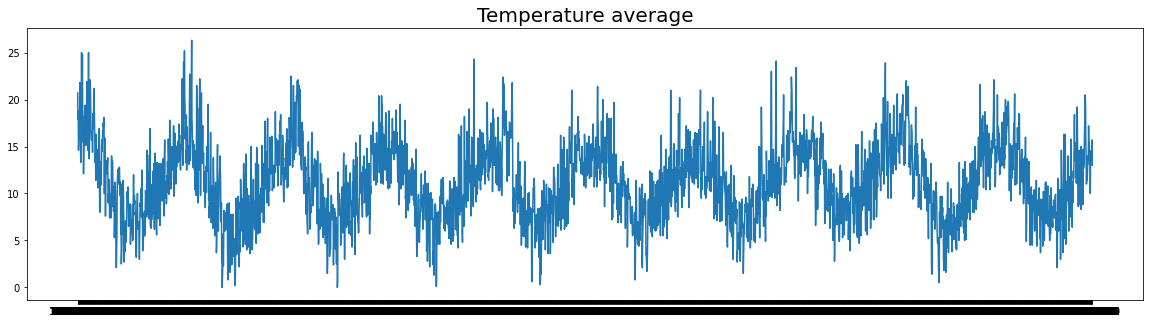

In [10]:
date = df['Date'].values
temp = df['Temp'].values

plt.figure(figsize=(20,5))
plt.plot(date, temp)
plt.title('Temperature average', fontsize = 20);

In [11]:
time = np.array(date)
series = np.array(temp)

time_split = 2000
X_train = time[:time_split]
X_test = time[time_split:]
y_train = series[:time_split]
y_test = series[time_split:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')is not None and logs.get('mae') <= mae_terkecil):
      print("\nMAE dibawah ", mae_terkecil , ", train data diberhentikan !")
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
train_set = windowed_dataset(series = y_train, window_size = 60, batch_size = 100, shuffle_buffer =  shuffle_buffer_size)
model = tf.keras.models.Sequential([
    # tf.keras.layers.Bidirectional(LSTM(60, activation='relu')),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
])

In [16]:
optimizer = tf.keras.optimizers.SGD(lr = 1.0000e-04, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(train_set, epochs = 100, callbacks=[callbacks]),

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
20/20 [==============================] - 3s 55ms/step - loss: 10.5765 - mae: 11.0754
Epoch 2/100
20/20 [==============================] - 1s 52ms/step - loss: 9.9710 - mae: 10.4695
Epoch 3/100
20/20 [==============================] - 1s 52ms/step - loss: 9.4079 - mae: 9.9064
Epoch 4/100
20/20 [==============================] - 1s 51ms/step - loss: 8.9840 - mae: 9.4820
Epoch 5/100
20/20 [==============================] - 1s 52ms/step - loss: 8.4870 - mae: 8.9847
Epoch 6/100
20/20 [==============================] - 1s 51ms/step - loss: 7.9150 - mae: 8.4119
Epoch 7/100
20/20 [==============================] - 1s 52ms/step - loss: 7.2709 - mae: 7.7663
Epoch 8/100
20/20 [==============================] - 1s 53ms/step - loss: 6.5415 - mae: 7.0348
Epoch 9/100
20/20 [==============================] - 1s 53ms/step - loss: 5.7170 - mae: 6.2079
Epoch 10/100
20/20 [==============================] - 1s 52ms/step - loss: 4.8240 - mae: 5.3089
Epoch 11/100
20/20 [==========================

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[time_split - window_size: -1, 0]

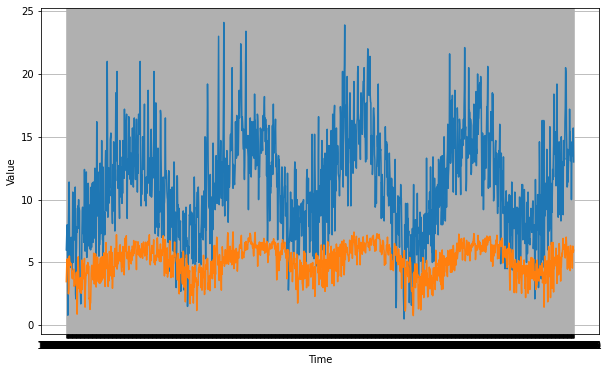

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(X_test, y_test)
plot_series(X_test, rnn_forecast)

In [19]:
tf.keras.metrics.mean_absolute_error(y_test, rnn_forecast).numpy()

array([7.7842774, 6.984799 , 6.135104 , ..., 5.2401505, 5.625834 ,
       5.4984274], dtype=float32)